# Redes Neurais com Pytorch

Pytorch possibilita a criação de redes profundas com facilidade através do módulo 'nn'.

In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Vamos usar o MNIST para esse teste, porém vamos usar como uma lista de valores  e não como uma imagem (CNN)

In [10]:
from torchvision import datasets, transforms
from torch import nn

In [4]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [5]:
# definir a tranformação para normalizar os dados
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [6]:
# baixar o e caregar o dataset
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [7]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Batchs de tamanho 64, como definido anteriormente, com amostras escolhidas randomicamente.

[64, 1, 28, 28], 64 amostras, 1 canal, 28X28 é a dimensão 


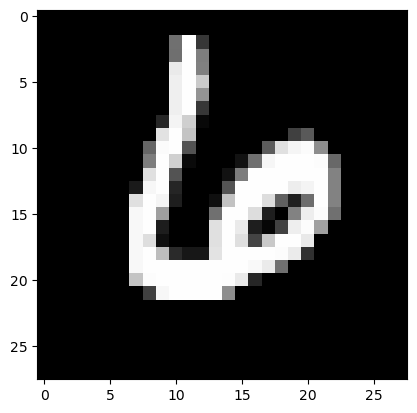

In [8]:
plt.imshow(images[1].numpy().squeeze() ,cmap='Greys_r')

## Implementação da rede

In [10]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        #camadas
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.output = nn.Linear( 64, 10)
        
        # funções de ativação
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.softmax(x)
        return x
        

In [11]:
model = Network()

In [12]:
model

Network(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
)

### Implementando mesma redo usando **torch.nn.functional**

In [8]:
import torch.nn.functional as F

In [14]:
class Network2(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        #camadas
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.output = nn.Linear( 64, 10)
        
        
        
    def forward(self, x):
        x = F.relu( self.hidden1(x))
        x = F.relu( self.hidden2(x))
        x = F.softmax( self.output(x), dim=1)
        
        return x
        

In [15]:
model2 = Network2()
model2

Network2(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

### Implementar usando o **nn.Sequential**

In [16]:
model3 = nn.Sequential(nn.Linear(784,128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1))

print(model3)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [17]:
print(model3[0])

model3[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[ 0.0167, -0.0043,  0.0074,  ..., -0.0180,  0.0061,  0.0201],
        [ 0.0261,  0.0322, -0.0182,  ...,  0.0330,  0.0323, -0.0199],
        [ 0.0193,  0.0090,  0.0263,  ...,  0.0091, -0.0330,  0.0032],
        ...,
        [-0.0248,  0.0310, -0.0295,  ...,  0.0285,  0.0117,  0.0020],
        [-0.0004, -0.0310,  0.0169,  ..., -0.0225, -0.0287, -0.0354],
        [-0.0097,  0.0043,  0.0162,  ...,  0.0154, -0.0249, -0.0027]],
       requires_grad=True)

## Forward mais calculo de perda

In [18]:
# Definição da função de perda (LOSS)
criterion = nn.NLLLoss()

In [19]:
# pegar o batch de amostras
images, labels = next(iter(trainloader))

# tornando unidimensional
images = images.view(images.shape[0], -1)

In [20]:
logits = model3(images)

Calculo da Perda

In [21]:
loss = criterion(logits, labels)
print(loss)

tensor(2.3058, grad_fn=<NllLossBackward0>)


## Backward 

Realiza o back propagation

In [22]:
loss.backward()

## Atualizar os pesos 

In [13]:
from torch import optim


In [27]:
optimizer = optim.SGD(model3.parameters(), lr=0.003)

Limpar os gradientes

In [28]:
optimizer.zero_grad()

Atualizar os parametros (pesos)

In [29]:
optimizer.step()

## Treinar a rede/

In [31]:
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad()
        
        output = model3(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.9455146607813805
Training loss: 0.8783546877441122
Training loss: 0.525199738742192
Training loss: 0.4285314717431312
Training loss: 0.3851222322185411


### Ver resultado

In [33]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# não computa os gradientes, acelarando a computação
with torch.no_grad():
    logps = model3(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

In [34]:
ps

tensor([[2.5885e-01, 2.4462e-07, 7.4054e-04, 8.7290e-03, 3.4940e-06, 6.8472e-03,
         1.2433e-06, 7.1087e-01, 1.6158e-03, 1.2350e-02]])

In [40]:
torch.max(ps)

tensor(0.7109)

In [41]:
torch.argmax(ps)

tensor(7)

In [42]:
import matplotlib.pyplot as plt

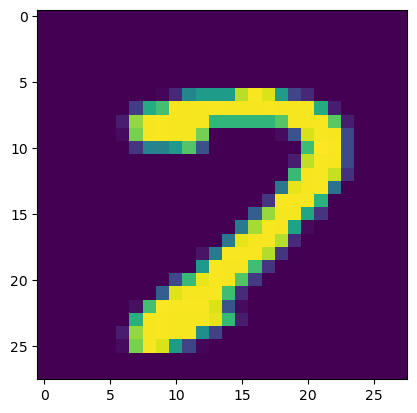

In [43]:
i = img.resize_(1, 28, 28).numpy().squeeze()
plt.imshow(i)
plt.show()

# Exemplo 2:

usando o fashion mnist


In [4]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [5]:
image, label = next(iter(trainloader))


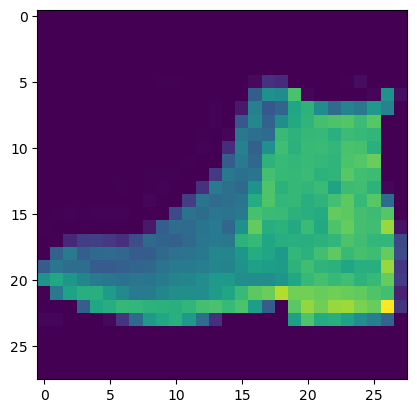

tensor(9)


In [6]:
plt.imshow(image[1,:].numpy().squeeze())
plt.show()

print(label[1])

- Definição da Rede

each image is 28x28 which is a total of 784 pixels, and there are 10 classes

In [11]:
model_fashion = nn.Sequential(nn.Linear(784,128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1))

print(model_fashion)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


Create your network and train it. First you'll want to define the criterion ( something like nn.CrossEntropyLoss) and the optimizer (typically optim.SGD or optim.Adam).

Then write the training code. Remember the training pass is a fairly straightforward process:

Make a forward pass through the network to get the logits
Use the logits to calculate the loss
Perform a backward pass through the network with loss.backward() to calculate the gradients
Take a step with the optimizer to update the weights

In [14]:
criterion_fashion = nn.CrossEntropyLoss()

In [15]:
optimizer_fashion = optim.SGD(model_fashion.parameters(), lr=0.03)

In [17]:
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        optimizer_fashion.zero_grad()
        
        output = model_fashion(images)
        loss = criterion_fashion(output, labels)
        loss.backward()
        optimizer_fashion.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.34489862848001757
Training loss: 0.33042712913933336
Training loss: 0.3190713670652813
Training loss: 0.3078495657313734
Training loss: 0.29697791156547665
Training loss: 0.2893902393244604
Training loss: 0.28152174399351515
Training loss: 0.2734450248957697
Training loss: 0.265726719289891
Training loss: 0.2587859367113759
